# Bayesian Parameter Estimation on MBL Data
## Allow for multiple strain datasets (vary R)
## Nathan Belliveau, Griffin Chure, Manuel Razo
**July 13, 2016**

In [1]:
import numpy as np
import pandas as pd
import emcee
import scipy.special
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import seaborn as sns
import corner
rc = {'lines.linewidth': 1.5,
      'axes.labelsize' : 14,
      'axes.titlesize' : 18,
      'axes.facecolor' : 'EBEBEB',
      'axes.edgecolor' : '000000',
      'axes.linewidth' : 0.75,
      'axes.frameon' : True,
      'xtick.labelsize' : 11,
      'ytick.labelsize' : 11,
      'font.family' : 'Droid Sans',
      'grid.linestyle' : ':',
      'grid.color' : 'a6a6a6',
      'mathtext.fontset' : 'stixsans',
      'mathtext.sf' : 'sans'}
plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans') 
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#------------------------------------------------------------------------------- 
%matplotlib notebook

/Users/Nathan/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/Users/Nathan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Our data consists of a set of fold-change in gene expression values from a set of experiments conducted at Woods Hole, MA at MBL Physiology. The purpose of this notebook is to perform a two-parameter fit on the active and inactive dissociation constants of the Lac repressor to IPTG. Using Bayes' rule, we can say that

$$
\begin{align}
P(\{a\} \vert D, I) &\propto P(D \vert \{a\}, I) P(\{a\} \vert I) \\
& \propto P(D \vert K_a, K_i, I) P(K_a \vert I) P(K_i \vert I)
\end{align}
$$


where $\{a\}$ is the set of dissociation constants for the active and inactive repressors ($K_a$ and $K_i$ repsectively), $D$ are our data, and $I$ is the prior information we have with regards to the system. Note that in this case we are considering that the two dissociation constants are independent parameters. This is probably not correct as it would make logical sense that the ability to bind inducer in the active vs inactive state uses a similar binding pocket and are therefore related. For now, it is not obvious how these two parameters are related mathematically, so we will treat them as completely independent. We can be more explicity with the functional form of our posterior as follows: 

$$
P(K_a, K_i \vert D, I) \propto \prod\limits_{i=1}^N \exp\left\{\frac{fc_i - fc(R, IPTG, \Delta\epsilon_r, K_a, K_i, \epsilon_{ai}))^2}{\sigma_i}\right\}\frac{1}{K_a^{max} - K_a^{min}}\cdot \frac{1}{K_i^{max} - K_i^{min}}\cdot \frac{1}{\sigma_i}
$$

where we have taken a uniform prior on the two dissociation constants. Using some of our physical intution, we known that a lower bound for the dissociation constant is that of the strongest non-covalent bond (biotin-streptavidin) and the upper bound would be Van der Waals interactions. 

Here D will include all strain datasets.

## Defining the log posterior

Below, we define the functions needed to perform our parameter estimation.

# Trying to sample $K_A$ and $K_I$ in log space 

In [77]:
#Load the data. 
data = pd.read_csv('../../data/mbl_2016/MBL_fc_data.csv')



In [78]:
#To pass in each strain dataset, I generate arrays containing 
# the IPTG concentration and fold-change values

rbs_delta = data[(data.strain=='delta') & (data.epsilon_r==-13.9)]
rbs_104 = data[(data.strain=='104') & (data.epsilon_r==-13.9)]
rbs_1147 = data[(data.strain=='1147') & (data.epsilon_r==-13.9)]
rbs_446 = data[(data.strain=='446') & (data.epsilon_r==-13.9)]
rbs_1027 = data[(data.strain=='1027') & (data.epsilon_r==-13.9)]
rbs_1L = data[(data.strain=='1L') & (data.epsilon_r==-13.9)]
rbs_rbs1 = data[(data.strain=='rbs1') & (data.epsilon_r==-13.9)]

#if only using a single strain's data, pass in to emcee like
# rbs_IPTG[1], rbs_fc[1], and R[1]

rbs_IPTG = [ rbs_delta.IPTG, rbs_104.IPTG, rbs_1147.IPTG, rbs_446.IPTG, \
            rbs_1027.IPTG, rbs_1L.IPTG, rbs_rbs1.IPTG ]
rbs_fc = [rbs_delta.fold_change, rbs_104.fold_change, rbs_1147.fold_change, \
          rbs_446.fold_change, rbs_1027.fold_change, rbs_1L.fold_change, \
          rbs_rbs1.fold_change]
R = [ 0, 11, 30, 62, 130, 610, 870]

In [79]:
# define a funciton to compute the fold change as a funciton of IPTG
def pact_log(IPTG, ea, ei, epsilon):
    '''
    Returns the probability of a repressor being active as described by the MWC
    model.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    epsilon : float.
        energy difference between the active and the inactive state
    Returns
    -------
    pact : float.
        probability of a repressor of being in the active state. Active state is
        defined as the state that can bind to the DNA.
    '''
    pact = (1.0 + IPTG * np.exp(ea))**2.0 / \
    ((1.0 + IPTG * np.exp(ea))**2.0 + np.exp(-epsilon) * (1.0 + IPTG * np.exp(ei))**2.0)
    return pact



In [80]:
def fold_change_log(IPTG, ea, ei, epsilon, R, epsilon_r):
    '''
    Returns the gene expression fold change according to the thermodynamic model
    with the extension that takes into account the effect of the inducer.
    Parameter
    ---------
    IPTG : array-like.
        concentrations of inducer on which to evaluate the function
    epsilon : float.
        energy difference between the active and the inactive state
    R : array-like.
        repressor copy number for each of the strains. The length of this array
        should be equal to the IPTG array. If only one value of the repressor is
        given it is asssume that all the data points should be evaluated with
        the same repressor copy number
    epsilon_r : array-like
        repressor binding energy. The length of this array
        should be equal to the IPTG array. If only one value of the binding
        energy is given it is asssume that all the data points 
        should be evaluated with the same repressor copy number
        
    Returns
    -------
    fold-change : float.
        gene expression fold change as dictated by the thermodynamic model.
   '''
    return 1.0 / (1.0 + 2.0 * R / 5.0E6 * pact_log(IPTG, ea, ei, epsilon) * \
            (1.0 + np.exp(-epsilon)) * np.exp(-epsilon_r))

In [81]:
def log_likelihood_log(param, IPTG, fc, R, ep_r, ep_ai):
#def log_likelihood_log(param, IPTG, fc):
    """
    Computes the log likelihood.
    """
    #Unpack the parameters.
    ea, ei = param
    # Use arbitrary sigma for now.
    sigma = 0.01
    # We need to sum over all strains (with unique R)
    # Set log likelihood to zero
    log_like = 0
    for i in range(0,len(R)):
        fc_theo = fold_change_log(IPTG[i], ea, ei, ep_ai, R[i], ep_r) 
        log_like = log_like + len(IPTG[i])*np.log(sigma) - np.sum((fc[i]-fc_theo)**2) / 2 / sigma**2
    return log_like    
        
           
#def log_post_log(param, IPTG, fc):
def log_post_log(param, IPTG, fc, R, ep_r, ep_ai):
    ea, ei = param
    if ea > 20 or ea < 0 or ei > 20 or ei < 0: 
        return -np.inf

    return log_likelihood_log(param, IPTG, fc, R, ep_r, ep_ai)

In [82]:
#Define the parameters for emcee
n_dim = 2 
n_walkers = 50
n_burn = 5000
n_steps = 1000 
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(0, 20, n_walkers)
p0[:,1] = np.random.uniform(0, 20, n_walkers)
#p0[:,2] = np.random.uniform(1E-5, 0.01, n_walkers)

In [83]:
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post_log,\
                args=(rbs_IPTG, rbs_fc, R, -13.9, 4.5),\
                threads=6)

In [84]:
#Do the burn in 
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

In [85]:
_ = sampler.run_mcmc(pos, n_steps)

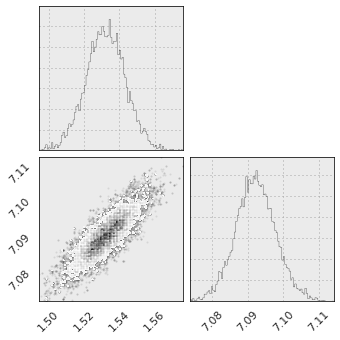

In [89]:
fig = corner.corner(sampler.flatchain[30000:], bins=100, plot_contours=False)

In [118]:
np.mean(sampler.flatchain[:, 1])

14.117913568705307

In [90]:
ea = np.mean(sampler.flatchain[30000:, 0])
ei = np.mean(sampler.flatchain[30000:, 1])

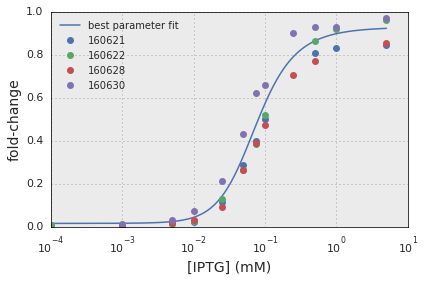

In [91]:
#lets take a look at fit with 1027 data
IPTG = np.logspace(-4, np.log10(5), 200)
fc_theory = fold_change_log(IPTG, ea, ei, 4.5, R=130, epsilon_r=-13.9)

plt.figure()
plt.plot(IPTG, fc_theory, '-b', label='best parameter fit')
for date in rbs_1027.date.unique():
    plt.plot(rbs_1027[rbs_1027.date==date].IPTG, rbs_1027[rbs_1027.date==date].fold_change, 'o',
            label=str(date))
plt.xscale('log')
plt.xlabel('[IPTG] (mM)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.tight_layout()

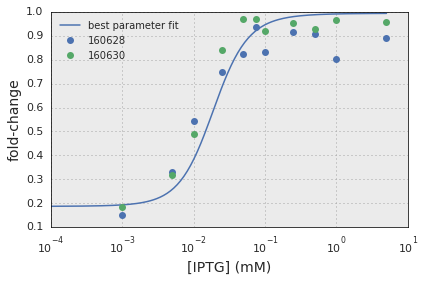

In [92]:
#lets take a look at fit with HG104 data
IPTG = np.logspace(-4, np.log10(5), 200)
fc_theory = fold_change_log(IPTG, ea, ei, 4.5, R=10, epsilon_r=-13.9)

plt.figure()
plt.plot(IPTG, fc_theory, '-b', label='best parameter fit')
for date in rbs_104.date.unique():
    plt.plot(rbs_104[rbs_104.date==date].IPTG, rbs_104[rbs_104.date==date].fold_change, 'o',
            label=str(date))
plt.xscale('log')
plt.xlabel('[IPTG] (mM)')
plt.ylabel('fold-change')
plt.legend(loc='upper left')
plt.tight_layout()

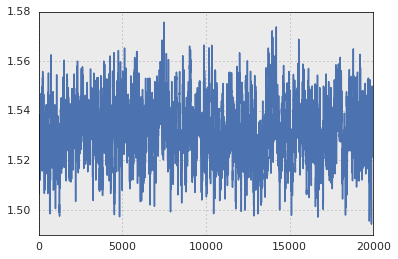

In [88]:
%matplotlib inline
plt.plot(sampler.flatchain[30000:, 0])


In [93]:
# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} mM
Ki = {1:.5f} mM
""".format(np.exp(-ea), np.exp(-ei)))

#aside: this is what was found with only 1027 data:
#Ka = 0.21 mM
#Ki = 0.00087 mM


The most probable parameters for the MWC model
----------------------------------------------
Ka = 0.22 mM
Ki = 0.00083 mM



Do these values make sense? I think so!

Note that if we expand the range of possible values (or even within some MCMC runs), the MCMC ends up finding other possible but unlikely values. I attempt to rationalize the tendency for MCMC to also come up with weird values when $e^{\epsilon_A}$ and $e^{\epsilon_I}$ are large or small. I suspend this is because it's gets stuck in a region of parameter space where $e^{\epsilon_A}$ and $e^{\epsilon_I}$ have little infuence on the fold-change and the posterior. Please double check.

In order to obtain the MWC parameters given the fold-change measurements Manuel took at MBL and a credible region on such parameters we will use a Bayesian approach to perform a non-linear regression.
Our theoretical model dictates that the fold change in gene expression is given by
\begin{equation}
    fc = \frac{1}{1 + \frac{2R p_{act}(C)}{N_{NS}} \left( 1 + e^{-\beta \Delta \epsilon_{ai}} \right)  e^{-\beta \Delta \epsilon_r}},
\end{equation}
where $p_{act}(C)$ is given by
\begin{equation}
    p_{act}(C) = \frac{\left( 1 + C e^{\epsilon_A}\right)^2}{\left( 1 + C e^{\epsilon_A}\right)^2 + e^{-\beta \epsilon_{ai}} \left( 1 + C e^{\epsilon_I}\right)^2}.
\end{equation}

We define $\epsilon_A = -\ln K_A$ and $\epsilon_I = -\ln K_I$ for convenience during the regression.

However, note that we find some particularly troublesome case when $e^{\epsilon_A}$ and $e^{\epsilon_I}$ are large. We can see this by re-writing $p_{act}(C)$ as follows:

\begin{equation}
p_{act}(C) = \frac{ 1 }{ 1 + e^{- \beta \epsilon_{ai}} \left( \frac{1 + C e^{\epsilon_I}}{1 + C e^{\epsilon_A}}\right)^2}
\end{equation}

For $C e^{\epsilon_I}$ and $C e^{\epsilon_A}$ >>1, we find that $p_{act}(C)$ will depend on the difference between $e^{\epsilon_A}$ and $e^{\epsilon_I}$:

\begin{equation}
p_{act}(C) = \frac{ 1 }{ 1 + e^{- \beta \epsilon_{ai}} \left( e^{ 2 (\epsilon_I - \epsilon_A)}\right)}
\end{equation}

For example, if $C = 0.005 M$,   $C \epsilon_A$ is equal to 1 when $\epsilon_A$ has a value of about 5.3 KBT.

For $C e^{\epsilon_I}$ and $C e^{\epsilon_I}$ << 1, we also see that these parameters will drop out of $p_{act}(C)$.
